In [1]:
#Basic libraries to load data
import numpy as np
import pandas as pd

#Libraries to proces data, make models and evaluate
from category_encoders import TargetEncoder, OneHotEncoder
from scipy import stats
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from MAPE import mean_absolute_percentage_error

#Libraries to plot
import matplotlib.pyplot as plt

In [2]:
#load data
data_path = "train.csv"
data = pd.read_csv(data_path)

#Combine variables that describes a similar thibg
data['total_goals']=data['goals_selection']+data['goal_champ']+data['goal_cup']+data['goal_continent']
data['total_assists']=data['assist_champ']+data['assist_cup']+data['assist_continent']
data['total_own']=data['own_goal_champ']+data['own_goal_cup']+data['own_goal_continent']
data['total_yellow']=data['yellow_card_champ']+data['yellow_card_cup']+data['yellow_card_continent']
data['total_second_yellow']=data['second_yellow_card_champ']+data['second_yellow_card_cup']+data['second_yellow_card_continent']
data['total_red']=data['red_card_champ']+data['red_card_cup']+data['red_card_continent']

total_labels=[ 'age', 'nation','league', 'team',
              'selections_nation', 'position', 'price','total_goals',
              'total_assists', 'total_own','total_yellow',
              'total_second_yellow', 'total_red'
       ]

data_total=data[total_labels]

#Removing outlayers
z = np.abs(stats.zscore(data_total.price))
outliers_indice =(np.where(z < 0.33))[0].tolist()
players_train_no_outliers1=data_total.iloc[outliers_indice,:]
players_train_no_outliers1.shape

(8205, 13)

In [3]:
X = players_train_no_outliers1
y = X.pop("price")

# select which encoder to use for each column
target_encoder_columns = ["nation",'league', "team", "position" ] 

one_hot_encoder_columns = [ ]

passthrough_columns = X.columns.to_list()
for col in [*target_encoder_columns, *one_hot_encoder_columns]:
    passthrough_columns.remove(col)

In [4]:
#definition of the transformer that does the encoding
transformer = make_column_transformer(
    (TargetEncoder(smoothing=0.2), target_encoder_columns),
    (OneHotEncoder(handle_unknown="ignore"), one_hot_encoder_columns),
    ("passthrough", passthrough_columns)
)

#pipeline that first applies the transformer and then the model
pipeline = make_pipeline(
    transformer,
    CatBoostRegressor(learning_rate= 0.10319249696425876, depth=15, l2_leaf_reg=1.5334286772460566, random_strength=15.164309160682233,
                      grow_policy='SymmetricTree', max_bin=201, min_data_in_leaf=34, bootstrap_type='Bernoulli', subsample=0.49248251229613105,
                      random_state=0)
)

#separation of training and test and execution of the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1,random_state=0)
pipeline.fit(X_train,y_train)
y_pred=pipeline.predict(X_test)

0:	learn: 621896.8795464	total: 465ms	remaining: 7m 44s
1:	learn: 596877.8533425	total: 820ms	remaining: 6m 49s
2:	learn: 575798.5708918	total: 1.16s	remaining: 6m 26s
3:	learn: 558265.8123439	total: 1.16s	remaining: 4m 49s
4:	learn: 538620.6826621	total: 1.18s	remaining: 3m 53s
5:	learn: 521551.4761700	total: 1.51s	remaining: 4m 10s
6:	learn: 512470.9699175	total: 1.83s	remaining: 4m 20s
7:	learn: 502448.4742866	total: 2.17s	remaining: 4m 28s
8:	learn: 488184.8669282	total: 2.49s	remaining: 4m 34s
9:	learn: 476285.4160602	total: 2.81s	remaining: 4m 38s
10:	learn: 468209.7846206	total: 3.13s	remaining: 4m 41s
11:	learn: 458783.8667588	total: 3.45s	remaining: 4m 44s
12:	learn: 450216.4969543	total: 3.54s	remaining: 4m 28s
13:	learn: 447753.5800258	total: 3.54s	remaining: 4m 9s
14:	learn: 439827.2487173	total: 3.87s	remaining: 4m 14s
15:	learn: 434312.3126798	total: 4.2s	remaining: 4m 18s
16:	learn: 427258.4046154	total: 4.53s	remaining: 4m 21s
17:	learn: 423737.0251131	total: 4.57s	rema

In [5]:
#Percentatge of the error in the prediction in the price
mean_squared_error_percentatge=mean_absolute_percentage_error(y_test, y_pred)
print(mean_squared_error_percentatge)

75.70639551223493


In [6]:
r2_score(y_test,y_pred)

0.5798421743769584

In [7]:
print (mean_squared_error(y_test, y_pred))

196675021328.72076


In [8]:
#Mean error in the price in euros
print(mean_squared_error(y_test, y_pred, squared=False))

443480.576044454


Text(0, 0.5, 'true value (M€)')

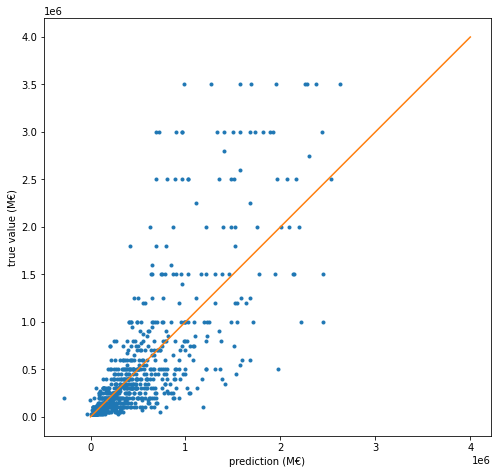

In [10]:
#Plot of the difference between the prediction and the real value
plt.figure(figsize=(8, 8))
plt.plot(y_pred, y_test, '.')
plt.plot((0, 4e6), (0, 4e6))
plt.gca().set_aspect(1)
plt.xlabel("prediction (M€)")
plt.ylabel("true value (M€)")

Text(0, 0.5, 'Players')

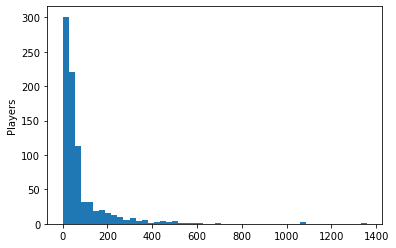

In [15]:
#Distribution of the error
error = np.abs((y_test - y_pred)/y_test) * 100
error.plot.hist( bins=50)
plt.ylabel("Players")